<a href="https://colab.research.google.com/github/paolomartine/Kaggle-udea-20251-Pruebas--saber-pro/blob/main/03_modelo_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:06:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy entrenamiento: 0.3473086642599278
Accuracy test: 0.34740794223826715


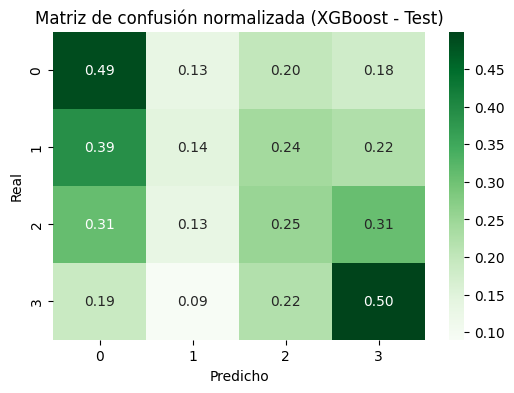

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar datos
data = pd.read_csv('train.csv')
data = data[['FAMI_EDUCACIONPADRE', 'FAMI_ESTRATOVIVIENDA', 'RENDIMIENTO_GLOBAL']]

# Limpiar datos
data.FAMI_EDUCACIONPADRE.values[data.FAMI_EDUCACIONPADRE.isna()] = 'no info'
data.FAMI_ESTRATOVIVIENDA.values[data.FAMI_ESTRATOVIVIENDA.isna()] = 'no info'

cmap = {
    'Estrato 1': 0.25, 'Estrato 2': 0.5, 'Estrato 3': 0.75,
    'Estrato 4': 1, 'Estrato 5': 1.25, 'Estrato 6': 1.5,
    'Sin Estrato': 0, 'no info': -1
}
data.FAMI_ESTRATOVIVIENDA = np.r_[[cmap[i] for i in data.FAMI_ESTRATOVIVIENDA]]

data.FAMI_EDUCACIONPADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in data.FAMI_EDUCACIONPADRE.values]

# One-hot encoding para FAMI_EDUCACIONPADRE
x = data.FAMI_EDUCACIONPADRE.values
FAMI_EDUCACIONPADRE_vals = sorted(np.unique(x))
FAMI_EDUCACIONPADRE_onehot_vals = {val: np.eye(len(FAMI_EDUCACIONPADRE_vals))[i] for i,val in enumerate(FAMI_EDUCACIONPADRE_vals)}
FAMI_EDUCACIONPADRE_onehot_enc = np.r_[[FAMI_EDUCACIONPADRE_onehot_vals[i] for i in data.FAMI_EDUCACIONPADRE]]
FAMI_EDUCACIONPADRE_df = pd.DataFrame(FAMI_EDUCACIONPADRE_onehot_enc, columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in FAMI_EDUCACIONPADRE_onehot_vals])
data = pd.concat([FAMI_EDUCACIONPADRE_df, data], axis=1).drop('FAMI_EDUCACIONPADRE', axis=1)

# Mapear target
y_col = 'RENDIMIENTO_GLOBAL'
rmap = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
rmapi = {v: k for k, v in rmap.items()}
data[y_col] = [rmap[i] for i in data[y_col]]
data = data[sorted(data.columns)]

# Separar variables
X = data[[c for c in data.columns if c != y_col]].values
y = data[y_col].values

# Split
Xtr, Xts, ytr, yts = train_test_split(X, y, train_size=0.8, random_state=42)

# Modelo XGBoost
model = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
model.fit(Xtr, ytr)

# Predicciones
preds_tr = model.predict(Xtr)
preds_ts = model.predict(Xts)

# Accuracy
print("Accuracy entrenamiento:", np.mean(preds_tr == ytr))
print("Accuracy test:", np.mean(preds_ts == yts))

# Confusion matrix normalizada
cm_ts = confusion_matrix(yts, preds_ts)
cm_ts = cm_ts / cm_ts.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_ts, annot=True, cmap='Greens', fmt=".2f")
plt.title("Matriz de confusión normalizada (XGBoost - Test)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# -----------------------------
# Predicción en test.csv
# -----------------------------
zt = pd.read_csv('test.csv')
zt_ids = zt['ID'].values
zt = zt[['FAMI_EDUCACIONPADRE', 'FAMI_ESTRATOVIVIENDA']]
zt.FAMI_EDUCACIONPADRE.values[zt.FAMI_EDUCACIONPADRE.isna()] = 'no info'
zt.FAMI_ESTRATOVIVIENDA.values[zt.FAMI_ESTRATOVIVIENDA.isna()] = 'no info'
zt.FAMI_ESTRATOVIVIENDA = np.r_[[cmap[i] for i in zt.FAMI_ESTRATOVIVIENDA]]
zt.FAMI_EDUCACIONPADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in zt.FAMI_EDUCACIONPADRE.values]
FAMI_EDUCACIONPADRE_onehot_enc = np.r_[[FAMI_EDUCACIONPADRE_onehot_vals[i] for i in zt.FAMI_EDUCACIONPADRE]]
FAMI_EDUCACIONPADRE_df = pd.DataFrame(FAMI_EDUCACIONPADRE_onehot_enc, columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in FAMI_EDUCACIONPADRE_onehot_vals])
zt = pd.concat([FAMI_EDUCACIONPADRE_df, zt], axis=1).drop('FAMI_EDUCACIONPADRE', axis=1)

# Igualar columnas
missing_cols = set(data.drop(y_col, axis=1).columns) - set(zt.columns)
for col in missing_cols:
    zt[col] = 0
zt = zt[data.drop(y_col, axis=1).columns]

# Predicciones
preds_test_data = model.predict(zt)
text_preds_test_data = [rmapi[i] for i in preds_test_data]

# Submission
submission = pd.DataFrame({'ID': zt_ids, 'RENDIMIENTO_GLOBAL': text_preds_test_data})
submission.to_csv("submission_xgboost.csv", index=False)
